# Load required libraries

In [1]:
from sympy import *
from sympy.abc import t
init_printing()

### Angle and their velocities

In [3]:
P, Q, R, phi, theta, psi = symbols('P Q R \\phi \\theta \\psi', real = True)

### Control variables
$\omega_1$ is the motor 1 velocity (rad/s) <br>
$\omega_2$ is the motor 2 velocity (rad/s) <br>
$\omega_3$ is the motor 3 velocity (rad/s) <br>
$\omega_4$ is the motor 4 velocity (rad/s) <br>

In [4]:
w1, w2, w3, w4 = symbols('\\omega_1 \\omega_2 \\omega_3 \\omega_4', real = True)
w = [w1, w2, w3, w4]

# Parameters

In [5]:
Mx, My, Mz = symbols('M_x M_y M_z', real = True) # Net Moment
Ix, Iy, Iz = symbols('I_x I_y I_z', real = True) # Moment of Intertia
g = symbols('g', real = True) # Gravity
Kt = symbols('K_T', real = True) # thrust factor
Km = symbols('K_M', real = True) # drag factor
dcm = symbols('d_{cm}', real = True) # distance from motors to the center of mass
m = symbols('m', real = True) # mass of quad
rx = symbols('r_x', real = True) # distance from accelerometer to center of mass
ry = symbols('r_y', real = True) # distance from accelerometer to center of mass
rz = symbols('r_z', real = True) # distance from accelerometer to center of mass
Jtp= symbols('J_{TP}', real = True)
acc_ux = symbols('\\mu_ax', real = True) # Accelerometer noise for channel x
acc_uy = symbols('\\mu_ay', real = True)
acc_uz = symbols('\\mu_az', real = True)
compass_ux = symbols('\\mu_cx', real = True) # Compass noise for channel x
compass_uy = symbols('\\mu_cy', real = True)
compass_uz = symbols('\\mu_cz', real = True)
compass_bx = symbols('b_cx', real = True) # Compass bias for channel x
compass_by = symbols('b_cy', real = True)
compass_bz = symbols('b_cz', real = True)
gyro_ux = symbols('\\mu_gx', real = True) # Gyroscope noise for channel x
gyro_uy = symbols('\\mu_gy', real = True)
gyro_uz = symbols('\\mu_gz', real = True)
gyro_bx = symbols('b_gx', real = True) # Gyroscope bias for channel x
gyro_by = symbols('b_gy', real = True)
gyro_bz = symbols('b_gz', real = True)
bar_u  = symbols('\\mu_bz', real = True) # Barometer noise for channel x
local_altitude = symbols('lc', real = True)

# Nonlinear equations

### Dynamics of the quadrotor concerning the rotations

In [6]:
theta = symbols('\\theta', real = True)
phi = symbols('\\phi', real = True)
psi = symbols('\\psi', real = True)
dtheta = symbols('\\dot{\\theta}', real = True)
dphi = symbols('\\dot{\\phi}', real = True)
dpsi = symbols('\\dot{\\psi}', real = True)
X = symbols('X', real = True)
Y = symbols('Y', real = True)
Z = symbols('Z', real = True)
dX = symbols('\\dot{X}', real = True)
dY = symbols('\\dot{Y}', real = True)
dZ = symbols('\\dot{Z}', real = True)

### Angular accelerations

In [7]:
ddtheta = ((Iy-Iz)/Ix)*dphi*dpsi   -Jtp*dphi*(-w1+w2-w3+w4)/Ix +dcm*Kt*(-w2**2 +w4**2)/Ix
ddphi   = ((Iz-Ix)/Iy)*dtheta*dpsi -Jtp*dtheta*(-w1+w2-w3+w4)/Iy +dcm*Kt*(-w1**2 +w3**2)/Iy
ddpsi   = ((Ix-Iy)/Iz)*dtheta*dphi +Km*(-w1**2 +w2**2 -w3**2 +w4**2)/Iz

### $\ddot{X}$, $\ddot{Y}$, $\ddot{Z}$ equations

In [8]:
ddX = ( sin(psi)*sin(phi) +cos(psi)*sin(theta)*cos(phi))*Kt*(w1**2 +w2**2 +w3**2 +w4**2)/m
ddY = (-cos(psi)*sin(phi) +sin(psi)*sin(theta)*cos(phi))*Kt*(w1**2 +w2**2 +w3**2 +w4**2)/m
ddZ = -g +cos(theta)*cos(phi)*Kt*(w1**2 +w2**2 +w3**2 +w4**2)/m

# Obtaining a linear model with 12 states
State vector: <br>
$x = \left[ \begin{array}{cccccccccccc} X & Y & Z & \dot{X} & \dot{Y} & \dot{Z} & \phi & \theta & \psi & \dot{\phi} & \dot{\theta} & \dot{\psi} \end{array} \right]^T$

In [9]:
x =  [X, Y, Z, dX, dY, dZ, phi, theta, psi, dphi, dtheta, dpsi]
dx = [dX, dY, dZ, ddX, ddY, ddZ, dphi, dtheta, dpsi, ddphi, ddtheta, ddpsi]

# Obtaining a linear model with 8 states
State vector: <br>
$x = \left[ \begin{array}{cccccccccccc} Z & \dot{Z} & \phi & \theta & \psi & \dot{\phi} & \dot{\theta} & \dot{\psi} \end{array} \right]^T$

In [10]:
x =  [ Z,  dZ,  phi,  theta,  psi,  dphi,  dtheta,  dpsi]
dx = [dZ, ddZ, dphi, dtheta, dpsi, ddphi, ddtheta, ddpsi]

### Equilibrium vector

In [11]:
xeq = {X:0, Y:0, Z:1, dX:0, dY:0, dZ:0, phi:0, theta:0, psi:0, dphi:0, dtheta:0, dpsi:0}

# Calculating $w$ for a initial condition

In [23]:
w0 = solve(ddZ.subs({w2:w1,w3:w1,w4:w1,theta:xeq[theta],phi:xeq[phi]}),w1)[1]
w0 = float(w0.subs({g:9.81,m:0.82,Kt:1.46e-05}))
weq= {w1:w0, w2:w0, w3:w0, w4:w0}
print 'w0 = '+str(w0)[0:8]+' rad/s'

w0 = 371.1376 rad/s


# Linearize and make matrices $A$ and $B$

In [14]:
A = zeros(len(x), len(x))
B = zeros(len(x), len(w))
for i,equation in enumerate(dx):
    for j,xj in enumerate(x):
        A[i,j] = equation.diff(xj)
for i,equation in enumerate(dx):
    for j,u in enumerate(w):
        B[i,j] = equation.diff(u)

# Replace the equilibrium point xeq to A,B matrices 
A = A.subs(xeq).subs(weq)
B = B.subs(xeq).subs({w1:w1,w2:w1,w3:w1,w4:w1})

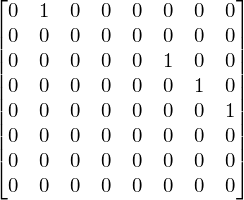

In [15]:
A

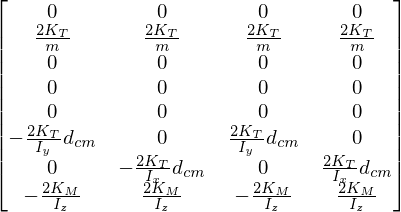

In [17]:
B/w1

# Non linear equations for sensors

### Accelerometer

In [16]:
ax = -g*sin(theta)          +dQ*rz -dR*ry +Q*(P*ry-Q*rx) -R*(R*rx-P*rz) +acc_ux
ay =  g*cos(theta)*sin(phi) +dR*rx -dP*rz +R*(Q*rz-R*ry) -P*(P*ry-Q*rx) +acc_uy
az =  g*cos(theta)*cos(phi) +dP*ry -dQ*rx +P*(R*rx-P*rz) -Q*(Q*rz-R*ry) +acc_uz

### Compass

In [17]:
Nx =  cos(theta)*cos(psi) +compass_ux +compass_bx
Ny =  cos(psi)*sin(phi)*sin(theta) - cos(phi)*sin(psi) +compass_uy +compass_by
Nz =  cos(psi)*cos(phi)*sin(theta) + sin(phi)*sin(psi) + compass_uz +compass_bz
Npsi= psi      +compass_ux +compass_bx

### Gyroscope

In [18]:
gx = P +gyro_ux +gyro_bx
gy = Q +gyro_uy +gyro_by
gz = R +gyro_uz +gyro_bz

### Barometer

In [19]:
bz = Z +bar_u +local_altitude

### C and D matrices

In [20]:
Y = [gx, gy, gz, ax, ay, az, Nx, Ny, Nz, bz]

In [21]:
C = zeros(len(Y), len(x))
D = zeros(len(Y), len(w))
for i,output in enumerate(Y):
    for j,xj in enumerate(x):
        C[i,j] = output.diff(xj)
for i,output in enumerate(Y):
    for j,u in enumerate(w):
        D[i,j] = output.diff(u)

# Replace the equilibrium point xeq to A,B matrices 
C = C.subs(dict(zip(x, xeq)))
#D = D.subs(dict(zip(w, weq)))

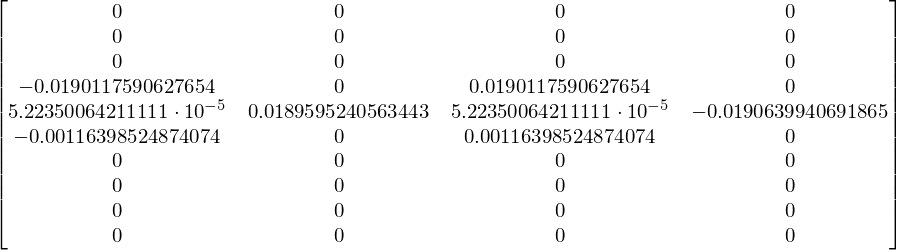

In [22]:
D.subs({Kt:1.46e-5,m:0.820,w1:371.1337,w2:371.1337,w3:371.1337,w4:371.1337,dcm:0.29,Ix:0.0081,Iy:0.0081,Iz:0.0162,Km:3.8001e-7,rx:0.003,ry:0,rz:-0.049})

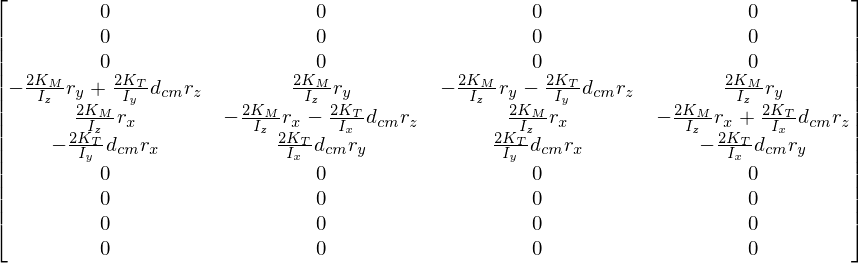

In [23]:
D.subs({w1:1,w2:1,w3:1,w4:1})

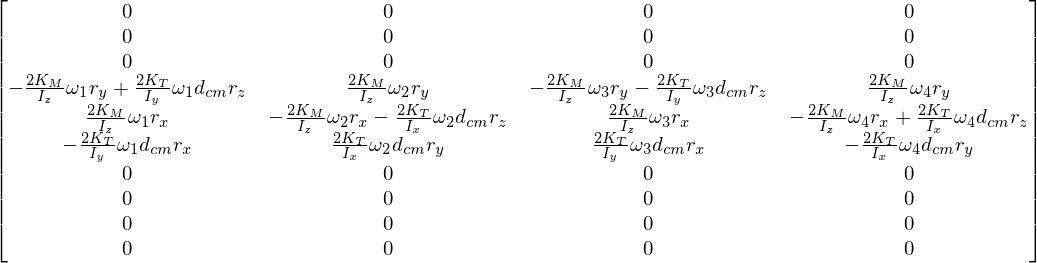

In [26]:
D

In [150]:
C.shape